In [40]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import mlab

import os
import json
from glob import glob

from uncertainties import unumpy as unp
from uncertainties import ufloat, umath

from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [41]:
NFFT = 1024
SAMPLE_RATE = 2_048_000
H21 = 1.420405751768e9  # Hz
#     1.420405751768

In [42]:
def load(dataset: str):
    raw_data = np.fromfile(dataset, np.complex64)
    with open(dataset.replace("raw.dat", "params.json"), "r") as file:
        params = json.load(file)
    
    spectrum, frequencies = mlab.psd(raw_data, NFFT=NFFT, Fs=SAMPLE_RATE)
    frequencies += params['frequency']

    return raw_data, (spectrum, frequencies), params

In [ ]:
spectra = []
freq = None

files = sorted(glob("../data/Vitesse*.dat"))
for file in files:
    _, (spectrum, freq), _ = load(file)
    spectra.append(spectrum)

_, (spec, _), _ = load("../data/galactic_test2_2025_02_28_13_46_12_raw.dat")
_, (noise, _), _ = load("../data/bc_test3_2025_02_28_13_31_31_raw.dat")
_, (bm, _), _ = load("../data/batiment_test2_2025_02_28_11_44_57_raw.dat")

In [44]:
def calculate_average(spectrum: np.ndarray) -> float:
    idx = np.r_[200:500,550:850]
    return np.mean(spectrum[idx])

In [45]:
def normalise_data(signal: np.ndarray, noise: np.ndarray) -> np.ndarray:
    return signal / noise

In [46]:
def clean_up(signal: np.ndarray, w: int = 10) -> np.ndarray:
    cleaned = np.convolve(signal, np.ones(w), 'same') / w
    return cleaned

In [47]:
def calculate_relative_speed(measured_frequency: float) -> float:
    return sc.constants.c * (H21 - measured_frequency) / measured_frequency

In [49]:
def gaussian(x: np.ndarray, A: float, B: float, mu: float, sigma: float) -> np.ndarray:
    return A + B * np.exp(-(x - mu)**2 / (2 * sigma**2))

In [97]:
def do_the_processing_mate(freq: np.ndarray, spectrum: np.ndarray, noise: np.ndarray, diplay: bool = True) -> ufloat:
    cleaned_signal = clean_up(normalise_data(spectrum, noise), w=20)

    H21_range = slice(640, 720)
    H21_center_est_idx = 680
    popt, pcov = sc.optimize.curve_fit(
        gaussian,
        freq[H21_range], np.log(cleaned_signal[H21_range]),
        p0=(np.log(calculate_average(cleaned_signal)), 0.01, freq[H21_center_est_idx], 2000),
        bounds=(
            (0, 0, 1.4201e9, 0),
            (100, 100, 1.4205e9, np.inf)
        )
    )
    perr = unp.uarray(popt, np.sqrt(np.diag(pcov)))
    mean = ufloat(perr[2].n, max(perr[2].s, perr[3].n))
    speed_brotha = calculate_relative_speed(mean)

    if display:
        print(f"Speed: {speed_brotha/1000:.3upP} km/s")
        plt.semilogy(freq, cleaned_signal)
        plt.semilogy(freq[650:720], cleaned_signal[650:720])
        plt.plot(freq, np.exp(gaussian(freq, *popt)))
        plt.axvline(H21, c='r')
        plt.axvline(popt[2], c='magenta')
    
    return speed_brotha

Speed: (19.1±13.6) km/s


19074.777153872437+/-13632.343117881965

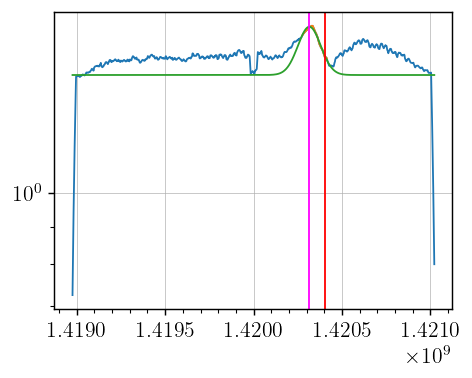

In [98]:
do_the_processing_mate(freq, spectra[0], noise)

Speed: (14.7±11.6) km/s


14730.56558023881+/-11612.263576224294

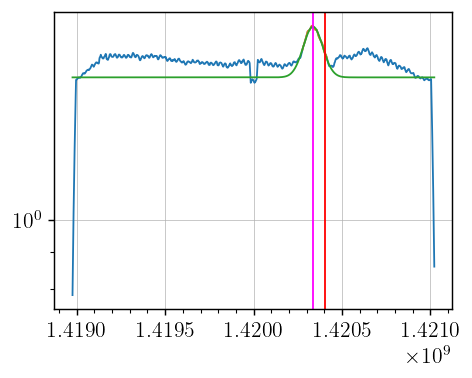

In [99]:
do_the_processing_mate(freq, spectra[1], noise)

Speed: (12.7±68.8) km/s


12672.440255977244+/-68771.63836913787

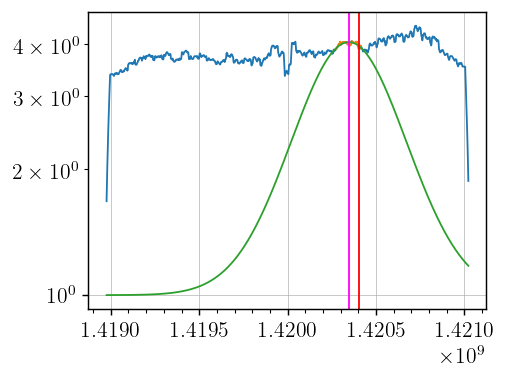

In [100]:
do_the_processing_mate(freq, spectra[2], noise)

Speed: (7.83±6.22) km/s


7831.59578260425+/-6222.742431381122

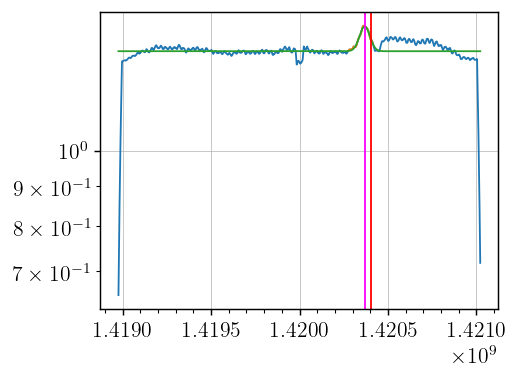

In [101]:
do_the_processing_mate(freq, spec, noise)